<a href="https://colab.research.google.com/github/zeinabmohamed/CIT690E-DeepLearning-Zeinab_Abdelmawla-191009/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1) Write a Python Colab Notebook: Use CIFAR-10 dataset and ResNet20, ResNet-32, ResNet-44 and ResNet-56 architectures in Pytorch to compute the
classification error and the number of parameters of each architecture as reported in
Table 6 of the following paper:
• He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image
recognition." In Proceedings of the IEEE CVPR 2016.
• Please note you should train your models on CIFAR-10 training set from scratch using the
instructions given in the above paper and in particular Section 4.2 and Figure 3.

## Imports

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyper-parameters


In [ ]:
num_epochs = 80
batch_size = 128
learning_rate = 0.1
momentum = 0.9

## Load the dataset CIFAR-10

In [ ]:
cifer10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifer10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Train loader

In [ ]:
train_dataloader = torch.utils.data.DataLoader(cifer10_trainset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(cifer10_testset, batch_size=batch_size, shuffle=False)

print("Training dataset size: ", len(cifer10_trainset))
print("Testing dataset size: ", len(cifer10_testset))

Training dataset size:  50000
Testing dataset size:  10000


## Resnet Model 

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
      


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

## Plain net

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class PlaiBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PlaiBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
    
        out = self.relu(out)
        return out

# ResNet
class PlainNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(PlainNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

## Create Model

In [ ]:
def createResnetModelWithDepth(depth):
  noOfBlocks = int((depth-2)/6)
  return ResNet(ResidualBlock, [noOfBlocks, noOfBlocks, noOfBlocks]).to(device)

In [ ]:
def createPlainModelWithDepth(depth):
  noOfBlocks = int((depth-2)/6)
  return PlainNet(PlaiBlock, [noOfBlocks, noOfBlocks, noOfBlocks]).to(device)

## For updating learning rate

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Train Fun

In [ ]:
def evaluate(model, data_loader, device):
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    
    with torch.no_grad():
      for data in data_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)

          y_true = np.concatenate((y_true, labels.cpu()))
          y_pred = np.concatenate((y_pred, predicted.cpu()))
    
    error = np.sum(y_pred != y_true) / len(y_true)
    return error


In [ ]:
# Train the model
import os

def trainModel(model,depth,isResnet):
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,weight_decay=1e-4)

# Run on GPU if available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  model.to(device)

  outdir ='./results'
  if not os.path.exists(outdir):
    os.mkdir(outdir)

  cols = ['epoch', 'train_loss', 'train_err', 'test_err']
  results_df = pd.DataFrame(columns=cols).set_index('epoch')
  
  total_step = len(train_dataloader)
  curr_lr = learning_rate
  results_file = f'results/plainnet{depth}.csv'
  if(isResnet):
      results_file = f'results/resnet{depth}.csv'

  for epoch in range(num_epochs):
    running_loss  = 0.0
    best_test_err = 1.0
    model.train()

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        #  optimize
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #Backward
        loss.backward()
        optimizer.step()
        
        # print average loss for last 50 mini-batches
        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)
    
    model.eval()

    train_loss = loss.item()
    train_err = evaluate(model, train_dataloader, device)
    test_err = evaluate(model, test_dataloader, device)
    results_df.loc[epoch] = [train_loss, train_err, test_err]
    results_df.to_csv(results_file)
    print(f'train_err: {train_err} test_err: {test_err}')

    model.eval()

  return train_loss

## Test Model

In [ ]:
# Test the model
def testModel(model):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

## calculateModelParams

In [ ]:
#Calculate the total number of parameters for model stride 2
from prettytable import PrettyTable

def calculateModelParams(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## Save Model

In [ ]:
# Save the model checkpoint
def saveModel(model,layerNo,isResnet):
  snapShotName = "plainnet%s.ckpt" % (layerNo)
  if(isResnet):
      snapShotName = "resnet%s.ckpt" % (layerNo)

  torch.save(model.state_dict(), snapShotName)
  print(snapShotName)

## **Resnet**

### Resnet20

In [ ]:
resnet20Model = createResnetModelWithDepth(depth=20)
trainModel(resnet20Model,20,True)
testModel(resnet20Model)
saveModel(resnet20Model,20,True)


cuda:0
Epoch [1/80], Step [100/391] Loss: 1.7583
Epoch [1/80], Step [200/391] Loss: 1.4016
Epoch [1/80], Step [300/391] Loss: 1.5154
train_err: 0.50458 test_err: 0.51
Epoch [2/80], Step [100/391] Loss: 0.9302
Epoch [2/80], Step [200/391] Loss: 0.8923
Epoch [2/80], Step [300/391] Loss: 0.9344
train_err: 0.3467 test_err: 0.3615
Epoch [3/80], Step [100/391] Loss: 0.8391
Epoch [3/80], Step [200/391] Loss: 0.9167
Epoch [3/80], Step [300/391] Loss: 0.7431
train_err: 0.3035 test_err: 0.3279
Epoch [4/80], Step [100/391] Loss: 0.8526
Epoch [4/80], Step [200/391] Loss: 0.7406
Epoch [4/80], Step [300/391] Loss: 0.6385
train_err: 0.23556 test_err: 0.2658
Epoch [5/80], Step [100/391] Loss: 0.5810
Epoch [5/80], Step [200/391] Loss: 0.7769
Epoch [5/80], Step [300/391] Loss: 0.6744
train_err: 0.1994 test_err: 0.2345
Epoch [6/80], Step [100/391] Loss: 0.5282
Epoch [6/80], Step [200/391] Loss: 0.3694
Epoch [6/80], Step [300/391] Loss: 0.4419
train_err: 0.2036 test_err: 0.2497
Epoch [7/80], Step [100/391

### **Resnet32**

In [ ]:
resnet32Model = createResnetModelWithDepth(32)
trainModel(resnet32Model,32,True)
testModel(resnet32Model)
saveModel(resnet32Model,32,True)

cuda:0
Epoch [1/80], Step [100/391] Loss: 1.9086
Epoch [1/80], Step [200/391] Loss: 1.7033
Epoch [1/80], Step [300/391] Loss: 1.5520
train_err: 0.5531 test_err: 0.5434
Epoch [2/80], Step [100/391] Loss: 1.3539
Epoch [2/80], Step [200/391] Loss: 1.1884
Epoch [2/80], Step [300/391] Loss: 1.1653
train_err: 0.438 test_err: 0.4437
Epoch [3/80], Step [100/391] Loss: 0.9479
Epoch [3/80], Step [200/391] Loss: 0.8176
Epoch [3/80], Step [300/391] Loss: 0.7896
train_err: 0.29098 test_err: 0.3124
Epoch [4/80], Step [100/391] Loss: 0.8023
Epoch [4/80], Step [200/391] Loss: 0.7223
Epoch [4/80], Step [300/391] Loss: 0.7319
train_err: 0.21334 test_err: 0.2431
Epoch [5/80], Step [100/391] Loss: 0.6316
Epoch [5/80], Step [200/391] Loss: 0.5673
Epoch [5/80], Step [300/391] Loss: 0.6680
train_err: 0.2018 test_err: 0.2366
Epoch [6/80], Step [100/391] Loss: 0.4239
Epoch [6/80], Step [200/391] Loss: 0.6145
Epoch [6/80], Step [300/391] Loss: 0.5521
train_err: 0.18416 test_err: 0.231
Epoch [7/80], Step [100/39

### **Resnet44**

In [ ]:
resnet44Model = createResnetModelWithDepth(44)
trainModel(resnet44Model,44,True)
testModel(resnet44Model)
saveModel(resnet44Model,44,True)

cuda:0
Epoch [1/80], Step [100/391] Loss: 1.8148
Epoch [1/80], Step [200/391] Loss: 1.6538
Epoch [1/80], Step [300/391] Loss: 1.5700
train_err: 0.58756 test_err: 0.5839
Epoch [2/80], Step [100/391] Loss: 1.4874
Epoch [2/80], Step [200/391] Loss: 1.5191
Epoch [2/80], Step [300/391] Loss: 1.1375
train_err: 0.4365 test_err: 0.4491
Epoch [3/80], Step [100/391] Loss: 0.9272
Epoch [3/80], Step [200/391] Loss: 1.0411
Epoch [3/80], Step [300/391] Loss: 0.8986
train_err: 0.38308 test_err: 0.3921
Epoch [4/80], Step [100/391] Loss: 0.9012
Epoch [4/80], Step [200/391] Loss: 0.7135
Epoch [4/80], Step [300/391] Loss: 0.6134
train_err: 0.2421 test_err: 0.2652
Epoch [5/80], Step [100/391] Loss: 0.7901
Epoch [5/80], Step [200/391] Loss: 0.6950
Epoch [5/80], Step [300/391] Loss: 0.6061
train_err: 0.21342 test_err: 0.2468
Epoch [6/80], Step [100/391] Loss: 0.5799
Epoch [6/80], Step [200/391] Loss: 0.5203
Epoch [6/80], Step [300/391] Loss: 0.5991
train_err: 0.17436 test_err: 0.2259
Epoch [7/80], Step [100

### **Resnet56**

In [ ]:
resnet56Model = createResnetModelWithDepth(56)
trainModel(resnet56Model,56,True)
testModel(resnet56Model)
saveModel(resnet56Model,56,True)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.0262
Epoch [1/80], Step [200/391] Loss: 1.8446
Epoch [1/80], Step [300/391] Loss: 1.6910
train_err: 0.64858 test_err: 0.6528
Epoch [2/80], Step [100/391] Loss: 1.6730
Epoch [2/80], Step [200/391] Loss: 1.3876
Epoch [2/80], Step [300/391] Loss: 1.3399
train_err: 0.4816 test_err: 0.4872
Epoch [3/80], Step [100/391] Loss: 1.3203
Epoch [3/80], Step [200/391] Loss: 1.2021
Epoch [3/80], Step [300/391] Loss: 0.9942
train_err: 0.34554 test_err: 0.3597
Epoch [4/80], Step [100/391] Loss: 0.7732
Epoch [4/80], Step [200/391] Loss: 0.8708
Epoch [4/80], Step [300/391] Loss: 0.8566
train_err: 0.26944 test_err: 0.2991
Epoch [5/80], Step [100/391] Loss: 0.5733
Epoch [5/80], Step [200/391] Loss: 0.5488
Epoch [5/80], Step [300/391] Loss: 0.6229
train_err: 0.2381 test_err: 0.272
Epoch [6/80], Step [100/391] Loss: 0.4981
Epoch [6/80], Step [200/391] Loss: 0.5300
Epoch [6/80], Step [300/391] Loss: 0.5181
train_err: 0.21272 test_err: 0.2552
Epoch [7/80], Step [100/

###Classification error and the number of parameters of each architecture

In [ ]:
calculateModelParams(resnet20Model)
calculateModelParams(resnet32Model)
calculateModelParams(resnet44Model)
calculateModelParams(resnet56Model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv.weight          |    432     |
|          bn.weight           |     16     |
|           bn.bias            |     16     |
|    layer1.0.conv1.weight     |    2304    |
|     layer1.0.bn1.weight      |     16     |
|      layer1.0.bn1.bias       |     16     |
|    layer1.0.conv2.weight     |    2304    |
|     layer1.0.bn2.weight      |     16     |
|      layer1.0.bn2.bias       |     16     |
|    layer1.1.conv1.weight     |    2304    |
|     layer1.1.bn1.weight      |     16     |
|      layer1.1.bn1.bias       |     16     |
|    layer1.1.conv2.weight     |    2304    |
|     layer1.1.bn2.weight      |     16     |
|      layer1.1.bn2.bias       |     16     |
|    layer1.2.conv1.weight     |    2304    |
|     layer1.2.bn1.weight      |     16     |
|      layer1.2.bn1.bias       |     16     |
|    layer1.2.conv2.weight     |  

876250

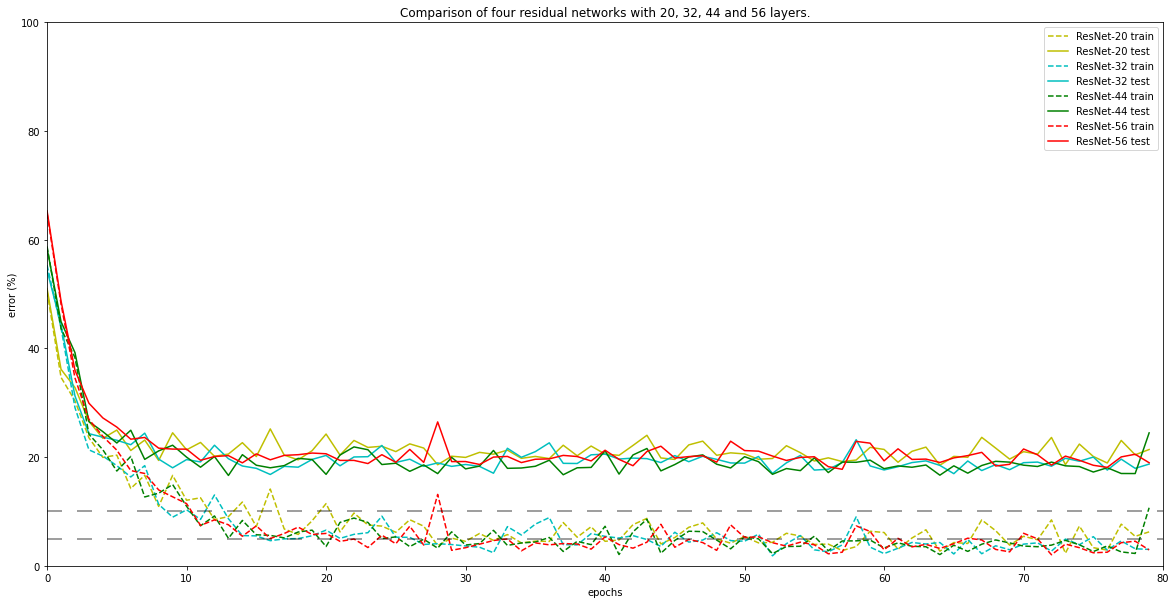

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 80, 0, 100])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
64,ResNet20,0.1851
16,ResNet32,0.1680
13,ResNet44,0.1662
57,ResNet56,0.1775


##Plain Network


### Plain20

In [ ]:
Plainnetwork20Model = createPlainModelWithDepth(20)
trainModel(Plainnetwork20Model,20,False)
testModel(Plainnetwork20Model)
saveModel(Plainnetwork20Model,20,False)


cuda:0
Epoch [1/80], Step [100/391] Loss: 1.7888
Epoch [1/80], Step [200/391] Loss: 1.6467
Epoch [1/80], Step [300/391] Loss: 1.4907
train_err: 0.5898 test_err: 0.5961
Epoch [2/80], Step [100/391] Loss: 1.3516
Epoch [2/80], Step [200/391] Loss: 1.3443
Epoch [2/80], Step [300/391] Loss: 1.3155
train_err: 0.45476 test_err: 0.4669
Epoch [3/80], Step [100/391] Loss: 1.2248
Epoch [3/80], Step [200/391] Loss: 1.0815
Epoch [3/80], Step [300/391] Loss: 1.0414
train_err: 0.35386 test_err: 0.3687
Epoch [4/80], Step [100/391] Loss: 0.9153
Epoch [4/80], Step [200/391] Loss: 0.9499
Epoch [4/80], Step [300/391] Loss: 0.8817
train_err: 0.31804 test_err: 0.3349
Epoch [5/80], Step [100/391] Loss: 0.8196
Epoch [5/80], Step [200/391] Loss: 0.7766
Epoch [5/80], Step [300/391] Loss: 0.8359
train_err: 0.26004 test_err: 0.2862
Epoch [6/80], Step [100/391] Loss: 0.6448
Epoch [6/80], Step [200/391] Loss: 0.6543
Epoch [6/80], Step [300/391] Loss: 0.6680
train_err: 0.23438 test_err: 0.2654
Epoch [7/80], Step [10

### Plain32

In [ ]:
Plainnetwork32Model = createPlainModelWithDepth(32)
trainModel(Plainnetwork32Model,32,False)
testModel(Plainnetwork32Model)
saveModel(Plainnetwork32Model,32,False)

cuda:0
Epoch [1/80], Step [100/391] Loss: 1.9023
Epoch [1/80], Step [200/391] Loss: 1.9064
Epoch [1/80], Step [300/391] Loss: 1.9327
train_err: 0.72784 test_err: 0.7265
Epoch [2/80], Step [100/391] Loss: 1.7070
Epoch [2/80], Step [200/391] Loss: 1.5256
Epoch [2/80], Step [300/391] Loss: 1.6693
train_err: 0.59822 test_err: 0.5968
Epoch [3/80], Step [100/391] Loss: 1.6517
Epoch [3/80], Step [200/391] Loss: 1.6581
Epoch [3/80], Step [300/391] Loss: 1.1921
train_err: 0.55412 test_err: 0.5499
Epoch [4/80], Step [100/391] Loss: 1.3512
Epoch [4/80], Step [200/391] Loss: 1.2976
Epoch [4/80], Step [300/391] Loss: 1.3022
train_err: 0.47572 test_err: 0.4813
Epoch [5/80], Step [100/391] Loss: 1.3848
Epoch [5/80], Step [200/391] Loss: 1.2698
Epoch [5/80], Step [300/391] Loss: 1.3730
train_err: 0.50132 test_err: 0.5104
Epoch [6/80], Step [100/391] Loss: 1.1100
Epoch [6/80], Step [200/391] Loss: 1.1609
Epoch [6/80], Step [300/391] Loss: 1.0006
train_err: 0.42386 test_err: 0.4382
Epoch [7/80], Step [1

### Plain44

In [ ]:
Plainnetwork44Model = createPlainModelWithDepth(44)
trainModel(Plainnetwork44Model,44,False)
testModel(Plainnetwork44Model)
saveModel(Plainnetwork44Model,44,False)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.0475
Epoch [1/80], Step [200/391] Loss: 2.0739
Epoch [1/80], Step [300/391] Loss: 1.9120
train_err: 0.79362 test_err: 0.7967
Epoch [2/80], Step [100/391] Loss: 2.0135
Epoch [2/80], Step [200/391] Loss: 1.9600
Epoch [2/80], Step [300/391] Loss: 1.9124
train_err: 0.71016 test_err: 0.7029
Epoch [3/80], Step [100/391] Loss: 1.9038
Epoch [3/80], Step [200/391] Loss: 1.8542
Epoch [3/80], Step [300/391] Loss: 1.6855
train_err: 0.65036 test_err: 0.6462
Epoch [4/80], Step [100/391] Loss: 1.7857
Epoch [4/80], Step [200/391] Loss: 1.8163
Epoch [4/80], Step [300/391] Loss: 1.7230
train_err: 0.65024 test_err: 0.6516
Epoch [5/80], Step [100/391] Loss: 1.6158
Epoch [5/80], Step [200/391] Loss: 1.6220
Epoch [5/80], Step [300/391] Loss: 1.6079
train_err: 0.61054 test_err: 0.6148
Epoch [6/80], Step [100/391] Loss: 1.6626
Epoch [6/80], Step [200/391] Loss: 1.5116
Epoch [6/80], Step [300/391] Loss: 1.4528
train_err: 0.59348 test_err: 0.6087
Epoch [7/80], Step [1

### Plain56

In [ ]:
Plainnetwork56Model = createPlainModelWithDepth(56)
trainModel(Plainnetwork56Model,56,False)
testModel(Plainnetwork56Model)
saveModel(Plainnetwork56Model,56,False)

cuda:0
Epoch [1/80], Step [100/391] Loss: 2.3008
Epoch [1/80], Step [200/391] Loss: 2.3014
Epoch [1/80], Step [300/391] Loss: 2.3085
train_err: 0.88842 test_err: 0.8869
Epoch [2/80], Step [100/391] Loss: 2.2360
Epoch [2/80], Step [200/391] Loss: 2.0109
Epoch [2/80], Step [300/391] Loss: 2.0283
train_err: 0.78258 test_err: 0.7799
Epoch [3/80], Step [100/391] Loss: 1.8754
Epoch [3/80], Step [200/391] Loss: 1.8944
Epoch [3/80], Step [300/391] Loss: 1.8443
train_err: 0.7302 test_err: 0.7266
Epoch [4/80], Step [100/391] Loss: 1.9304
Epoch [4/80], Step [200/391] Loss: 1.8760
Epoch [4/80], Step [300/391] Loss: 1.8628
train_err: 0.71092 test_err: 0.7069
Epoch [5/80], Step [100/391] Loss: 1.9096
Epoch [5/80], Step [200/391] Loss: 1.8291
Epoch [5/80], Step [300/391] Loss: 1.8212
train_err: 0.67334 test_err: 0.6783
Epoch [6/80], Step [100/391] Loss: 1.8454
Epoch [6/80], Step [200/391] Loss: 1.6671
Epoch [6/80], Step [300/391] Loss: 1.8182
train_err: 0.65722 test_err: 0.6568
Epoch [7/80], Step [10

###Classification error and the number of parameters of each architecture

In [ ]:
calculateModelParams(Plainnetwork20Model)
calculateModelParams(Plainnetwork32Model)
calculateModelParams(Plainnetwork44Model)
calculateModelParams(Plainnetwork56Model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv.weight          |    432     |
|          bn.weight           |     16     |
|           bn.bias            |     16     |
|    layer1.0.conv1.weight     |    2304    |
|     layer1.0.bn1.weight      |     16     |
|      layer1.0.bn1.bias       |     16     |
|    layer1.0.conv2.weight     |    2304    |
|     layer1.0.bn2.weight      |     16     |
|      layer1.0.bn2.bias       |     16     |
|    layer1.1.conv1.weight     |    2304    |
|     layer1.1.bn1.weight      |     16     |
|      layer1.1.bn1.bias       |     16     |
|    layer1.1.conv2.weight     |    2304    |
|     layer1.1.bn2.weight      |     16     |
|      layer1.1.bn2.bias       |     16     |
|    layer1.2.conv1.weight     |    2304    |
|     layer1.2.bn1.weight      |     16     |
|      layer1.2.bn1.bias       |     16     |
|    layer1.2.conv2.weight     |  

876250

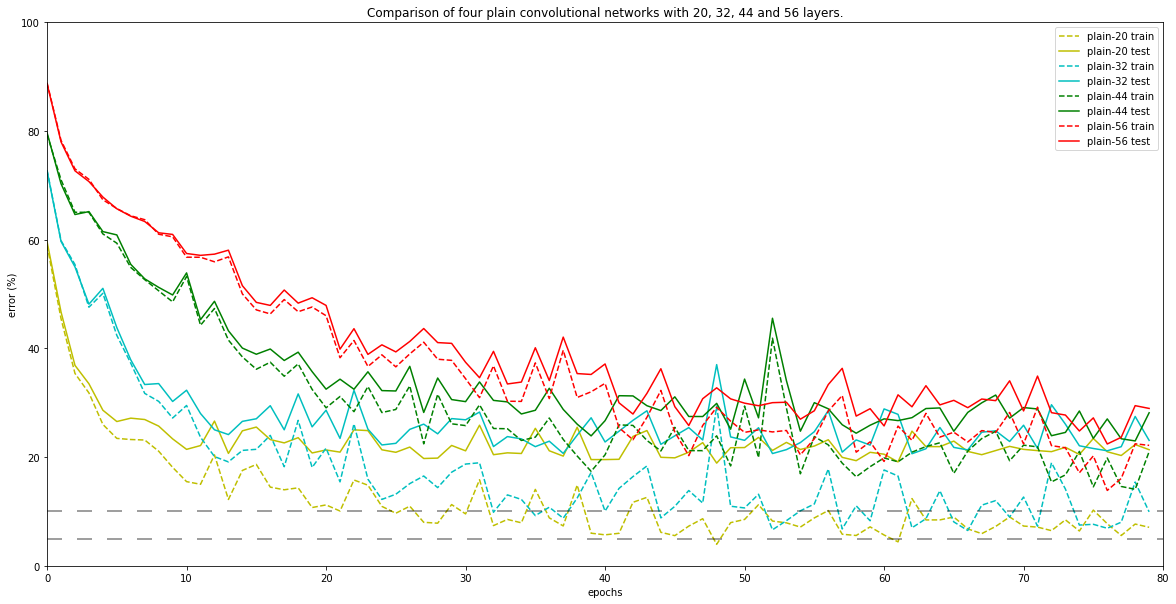

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 80, 0, 100])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

,model,test_err
48,PlainNet20,0.1889
62,PlainNet32,0.2062
78,PlainNet44,0.2297
76,PlainNet56,0.2241


 ##Q2) In the same Notebook, plot the classification error vs. the number of epochs for the above 4 ResNet architectures and in addition those generated by using deep CNN models without residual links (plain network presented at Figure 3middle of the above paper) of depth 20, 32, 44 and 56 layers, and

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


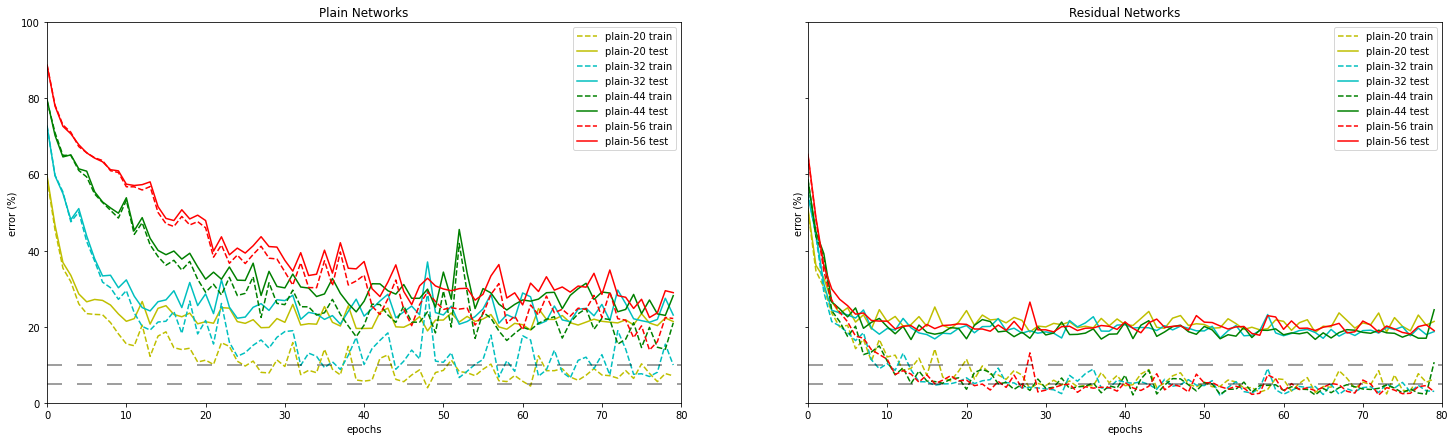

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 80, 0, 100])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')

##Q3)Explain the effect of increasing the number of layers in each architecture type (ResNet vs. Plain network). 

With more than 20 layers, to outperform shallower networks. That observation is reproduced here with the deepest 56-layer residual network outperforming all other networks tested, whilst the equivalent 56 layer plain network performed the worst.

The residual layers improved the performance of smaller networks, for example in Figure 6. the 20-layer ResNet outperforms its 'plain' counterpart. That result is also reproduced here with the residual 20-layer network outperforming the plain network by approx 1%.
